# **Summer 2022 Data Science Intern Challenge by Xin Li**

##  **Preparation. Import Packages and Data**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import seaborn as sns
import numpy as np
sns.set()

In [3]:
data_path = '/content/drive/MyDrive/DS Challenge/Shopify/dataset1.xlsx'
data=pd.read_excel(data_path)

## **Section 1. Exploratory Data Analysis (EDA)**

In [4]:
# quick look at the dataset
data.head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
0,1,53,746,224,2,cash,2017-03-13 12:36:56
1,2,92,925,90,1,cash,2017-03-03 17:38:52
2,3,44,861,144,1,cash,2017-03-14 04:23:56
3,4,18,935,156,1,credit_card,2017-03-26 12:43:37
4,5,18,883,156,1,credit_card,2017-03-01 04:35:11


In [5]:
# check data types for each columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   order_id        5000 non-null   int64         
 1   shop_id         5000 non-null   int64         
 2   user_id         5000 non-null   int64         
 3   order_amount    5000 non-null   int64         
 4   total_items     5000 non-null   int64         
 5   payment_method  5000 non-null   object        
 6   created_at      5000 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(5), object(1)
memory usage: 273.6+ KB


In [6]:
# check if null values exist
null_check = data.isnull().sum().to_frame()
null_check.columns = ['number_null']
null_check

,number_null
order_id,0
shop_id,0
user_id,0
order_amount,0
total_items,0
payment_method,0
created_at,0


In [7]:
# check the general statistic description of columns related to the target metric
data[['order_amount','total_items']].describe()

,order_amount,total_items
count,5000.000000,5000.00000
mean,3145.128000,8.78720
std,41282.539349,116.32032
min,90.000000,1.00000
25%,163.000000,1.00000
50%,284.000000,2.00000
75%,390.000000,3.00000
max,704000.000000,2000.00000


## **Section 2. Target Metric Calculation**

Over the given 30 days window, the goal metric ***average order value*** can be calculated through
AOV = mean(order_amount) 

In [8]:
AOV = np.mean(data['order_amount'])
AOV

3145.128

As indicated, the naive calculation of AOV returns a very high value and seems to violate our common sense that sneakers should be a relatively affordable goods. 

### To diagnose the problem, I will deep dive the data in 4 ways as follows.
> **1. Check if any anomalies exist in the order_amount.** 
> 
> Extremely high value can easily affected the overall average value, so I want to start with checking if any anomalies exist in order_amount. From the EDA part, I actually can see the evidence of anomaly data since the max values of order_amount is much larger than its median value. And the standard deviation of the column is also high, so it is very likely that there exists anomalies in order_amount.
> 
> **2. Breakdown the target metric into component metrics.** 
> 
>Order_amount can be breakdown into total_items and price_per_item, so we need to derive new feature price_per_item for further analysis because the anomaly in order_amount may actually arise from the anomaly in its component metrics. 
> 
>  **3. Segment AOV by shop_id, user_id and payment_method.** 
> 
>If the anomalies exist, I would like to further check if they arise from some particular shop, user or payment_method.
> 
> **4. Check temporal factor by plotting the time series trend of AOV.** 
> 
>The temporal analysis can help us to check if the high AOV is due to a sudden change or a progressive change, i.e., it is increased steadily over multiple days.


## **Section 3. Deep-dive Analysis (Question 1)** 



### 3.1 Box-plot: check anomalies


We can first have a look at the distribution of order_amount. It seems that the majority of the order_amount is less than 100,000.

Text(0, 0.5, 'Count')

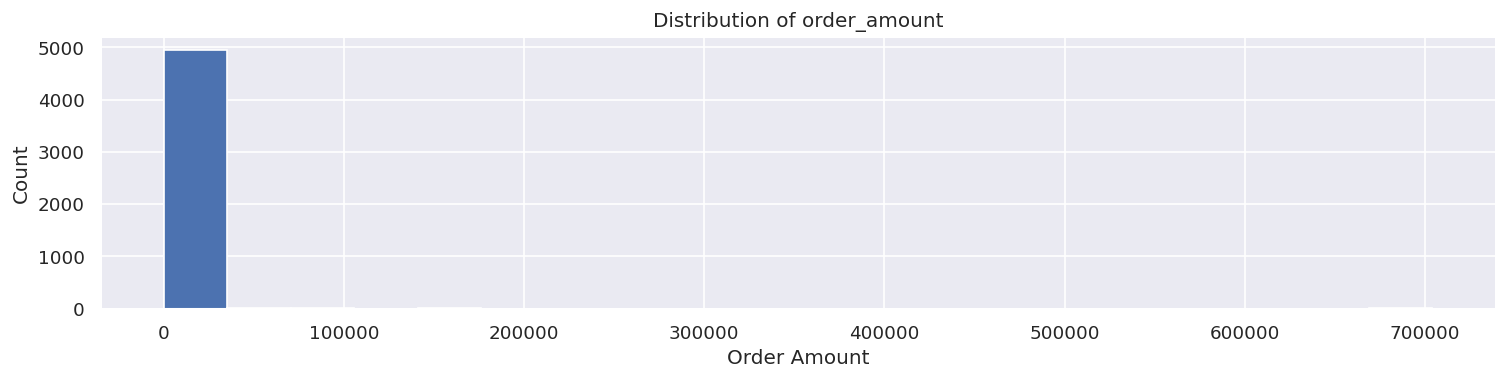

In [9]:
figure(figsize=(15, 3), dpi=120)
plt.hist(data['order_amount'],bins=20)
plt.title('Distribution of order_amount')
plt.xlabel('Order Amount')
plt.ylabel('Count')

Then we can plot the boxplot to further check whether outliers exist. Here, the boxplot does not show up clearly due to the domination of extremely high values.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


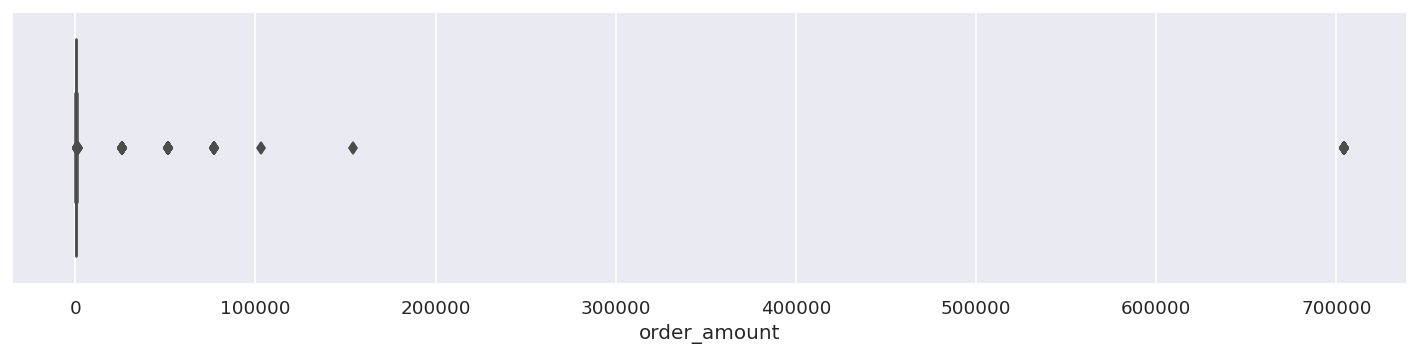

In [10]:
figure(figsize=(15, 3), dpi=120)
sns.boxplot(data['order_amount'])

According to boxplot, data points out of the range (Q1-1.5IQR, Q3+1.5IQR) can be regarded as outliers. Now, more specifically, we can focus on the outliers that exceeds the Q3+1.5IQR upper bound in the above boxplot because the values of order_amount are positive.

In [11]:
#first, calculate the upper bound in the boxplot, which is Q3+1.5*IQR
upper_bound = data['order_amount'].quantile(0.75) + 1.5*(data['order_amount'].quantile(0.75)-data['order_amount'].quantile(0.25))
upper_bound

730.5

In [12]:
#calculate the number of orders with outlier values in order_amount
print('The number of orders with order_amount less than upper bound:',data[data['order_amount']<=upper_bound].shape[0])
print('The number of orders with order_amount exceeding upper bound:',data[data['order_amount']>upper_bound].shape[0])

The number of orders with order_amount less than upper bound: 4859
The number of orders with order_amount exceeding upper bound: 141


Thus, according to the boxplot, there are 141 extremely high values in order_amount. Let's see how these outliers affect the value of AOV.


In [13]:
# Let's divide the data by the upper_bound of order_amount.
group1 = data[data['order_amount']<=upper_bound]
group2= data[data['order_amount']>upper_bound]

In [14]:
# contribution of the three groups of data to the AOV [histogram]
print('AOV of orders with order_amount less than upper bound', np.mean(group1['order_amount']))
print('AOV of orders with order_amount exceeding upper bound', np.mean(group2['order_amount']))

AOV of orders with order_amount less than upper bound 293.7153735336489
AOV of orders with order_amount exceeding upper bound 101407.63829787234


In [15]:
np.mean(group2['order_amount'])/np.mean(group1['order_amount'])

345.2581901922637

Here, we can see the AOV of orders with outliers in order_amount is 345 times larger than that of orders without outliers. And this is why the naive calculation of AOV over the 30 days window returns a relatively unafforadable price of sneakers.

We can also have a closer look at that the two groups of orders (with / without outliers in order_amount) have a distinct distribution in order_amount by plotting two seperate boxplots of order_amount.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


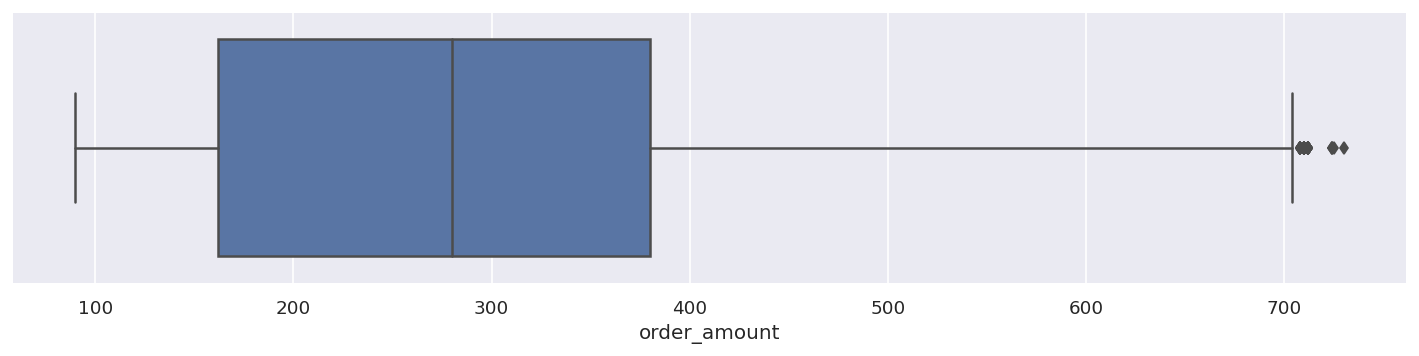

In [16]:
#Box-plot of order_amount in group1 (without outliers)
figure(figsize=(15, 3), dpi=120)
sns.boxplot(group1['order_amount'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


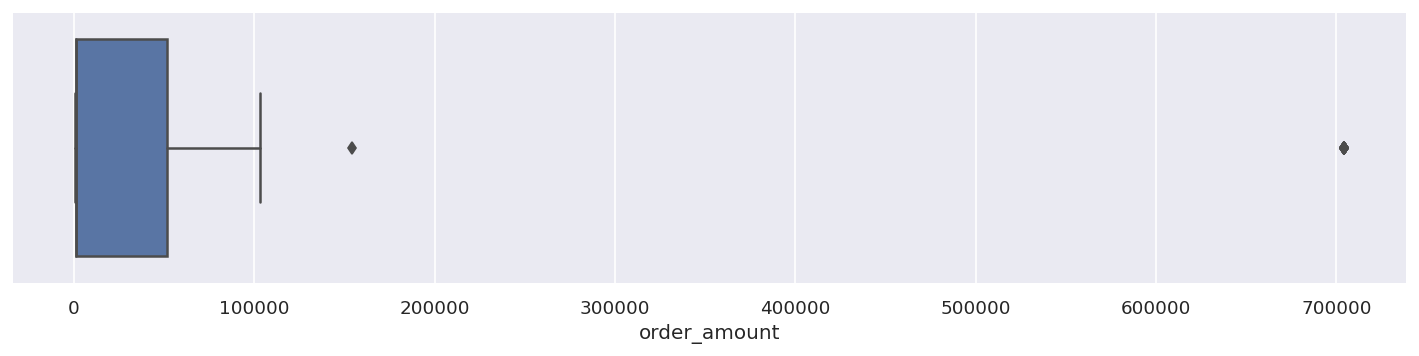

In [17]:
#Box-plot of order_amount in group2 (with outliers)
figure(figsize=(15, 3), dpi=120)
sns.boxplot(group2['order_amount'])

To further check how the anomalies impact AOV, such as, which records are associated with an extreme value of AOV, and why these records have such a large value of AOV, more deep-dive analysis need to be conducted. Here, I choose to start with decomposing the goal metric and bringing in auxiliary feature, price_per_item, and to check that whether there are anomalies in the two component metrics that leads to high value in AOV.

### 3.2 Target metric decomposition and auxiliary feature creation

As order_amount = total_items * price_per_item, we can bring in the auxiliary feature 'price_per_item' into analysis.

In [18]:
# creating price_per_item (price_per_item should be the same for the same store)
data['price_per_item'] = data['order_amount']/data['total_items']
data.head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at,price_per_item
0,1,53,746,224,2,cash,2017-03-13 12:36:56,112.0
1,2,92,925,90,1,cash,2017-03-03 17:38:52,90.0
2,3,44,861,144,1,cash,2017-03-14 04:23:56,144.0
3,4,18,935,156,1,credit_card,2017-03-26 12:43:37,156.0
4,5,18,883,156,1,credit_card,2017-03-01 04:35:11,156.0


#### (1) Check if there exists anomalies in total_items

It seems that total_items==2000 is a outlier.

Text(0, 0.5, 'Total_items')

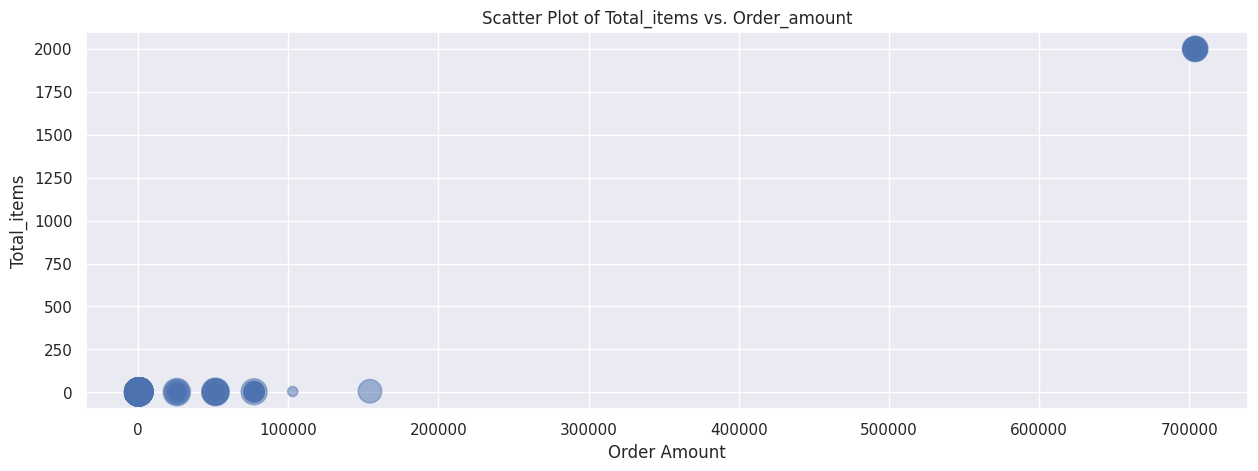

In [19]:
np.random.seed(200)
figure(figsize=(15, 5), dpi=100)
N = len(data['order_amount'])
area = (20 * np.random.rand(N)) **2
plt.scatter(data['order_amount'], data['total_items'], s=area,alpha=0.5)
plt.title('Scatter Plot of Total_items vs. Order_amount')
plt.xlabel('Order Amount')
plt.ylabel('Total_items')

By removing total_items = 2000, the boxplot of total_items seems to be more normal.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


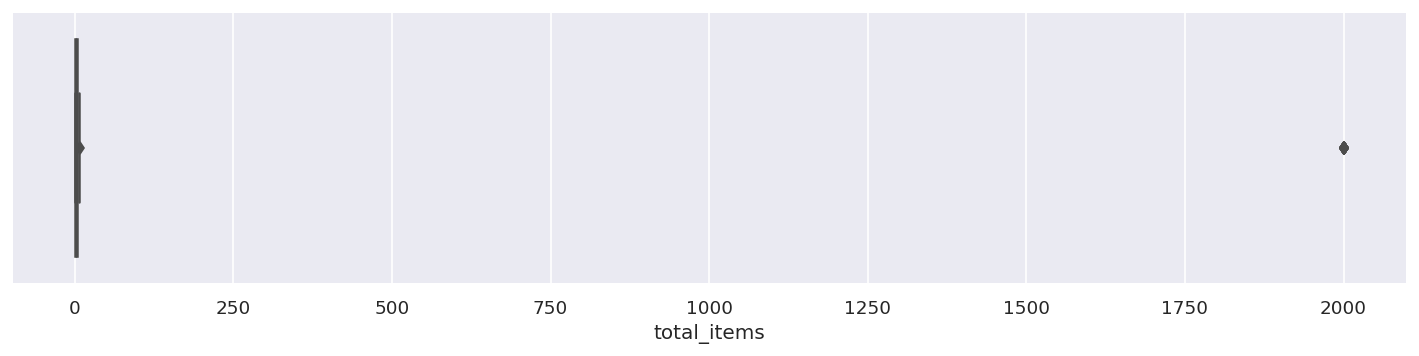

In [20]:
#boxplot of total_items without deleting total_items = 2000
figure(figsize=(15, 3), dpi=120)
sns.boxplot(data['total_items'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


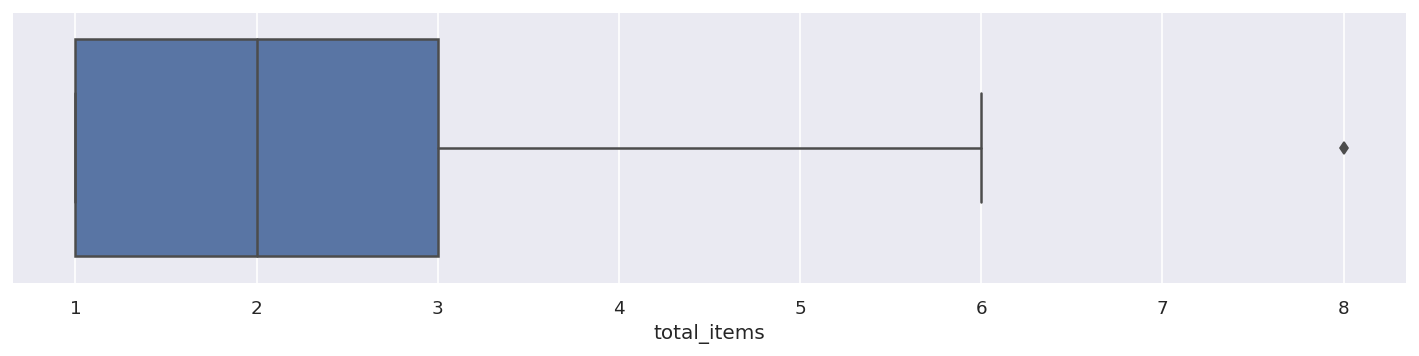

In [21]:
#boxplot after deleting total_items = 2000
figure(figsize=(15, 3), dpi=120)
sns.boxplot(data[data['total_items']!=2000]['total_items'])

Check the AOV with and without total_items = 2000. Without data with total_items = 2000, the AOV is lowered by a lot.

In [22]:
print('AOV (all data):',data['order_amount'].mean())
print('AOV (after deleting data with total_items = 2000):',data[data['total_items']!=2000]['order_amount'].mean())

AOV (all data): 3145.128
AOV (after deleting data with total_items = 2000): 754.0919125025085


#### (2) Check if there exists anomalies in *price_per_item*

Similarly, check if there exists anomalies in price_per_item. It seems that price_per_item above 25,000 is much higher than the others. It also violates our commen sense of the price of a pair of sneakers.

Text(0, 0.5, 'Price_per_item')

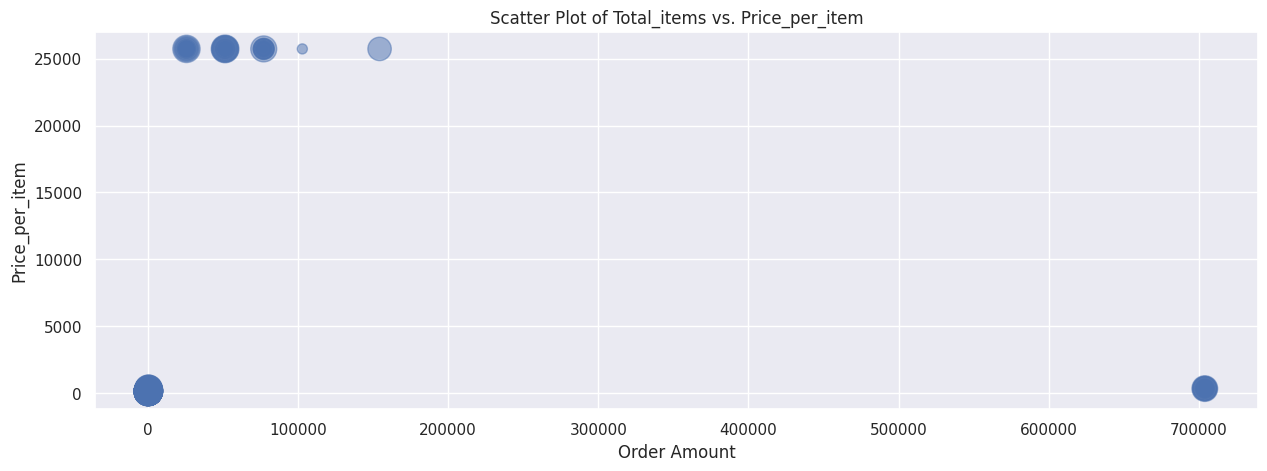

In [23]:
np.random.seed(200)
figure(figsize=(15, 5), dpi=100)
N = len(data['order_amount'])
area = (20 * np.random.rand(N)) **2
plt.scatter(data['order_amount'], data['price_per_item'], s=area,alpha=0.5)
plt.title('Scatter Plot of Total_items vs. Price_per_item')
plt.xlabel('Order Amount')
plt.ylabel('Price_per_item')

By removing data with price_per_item higher than 25000, the boxplot of total_items seems to be more normal.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


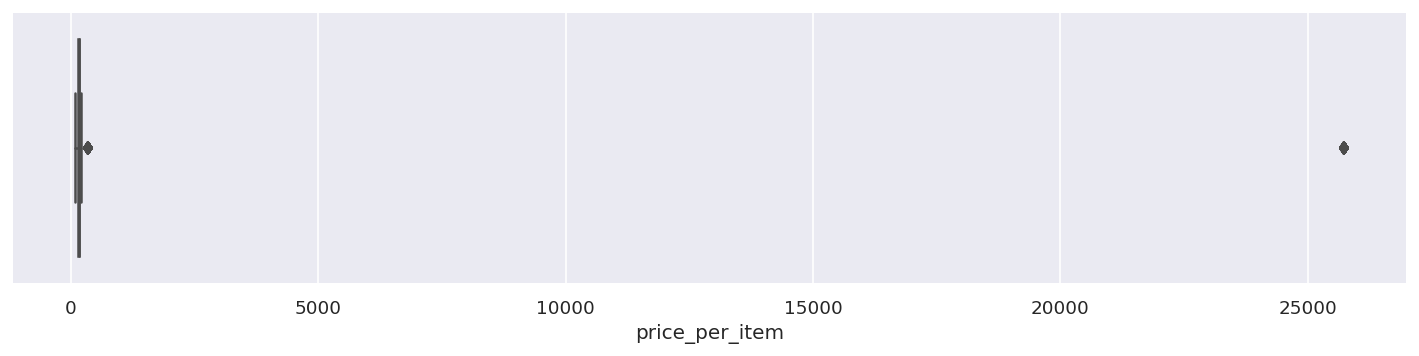

In [24]:
figure(figsize=(15, 3), dpi=120)
sns.boxplot(data['price_per_item'])

In [ ]:
#data[data['price_per_item']>25000]['price_per_item']
#25725

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


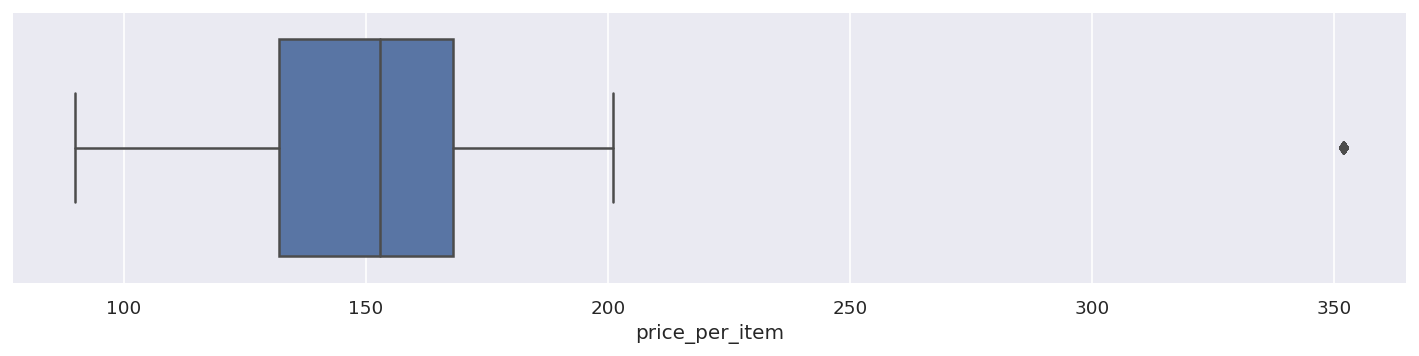

In [25]:
#boxplot after deleting price_per_item = 25725
figure(figsize=(15, 3), dpi=120)
sns.boxplot(data[data['price_per_item']!=25725]['price_per_item'])

After further deleting data with price_per_items = 25725, the AOV decreased by over a half than the one after deleting data with total_items = 2000.

In [26]:
print('AOV (all data):',data['order_amount'].mean())
print('AOV (after deleting data with price_per_items = 25725):',data[(data['price_per_item']!=25725)&(data['total_items']!=2000)]['order_amount'].mean())

AOV (all data): 3145.128
AOV (after deleting data with price_per_items = 25725): 302.58051448247926


Therefore, we can say that the extremly high values in price_per_items (25725) and total items (2000) is one cause to the high value in AOV.

However, we cannot just delete the anomalies data. To further diagnoise the the reason of a high value in AOV, I'd like to further segment AOV from different factors to check whether extremely high values in order_amount is caused by particular shop, user or payment method.

### 3.3 Segment AOV by shop, user and payment method.

Here, as our goal is to explore the cause to high value of AOV, i.e, the cause to outliers in order_amount, we mainly focus on the group2 data (with outliers in order_amount; outliers are derived from boxplot).

### (1) AOV group by shop_id

Text(0, 0.5, 'Shop id')

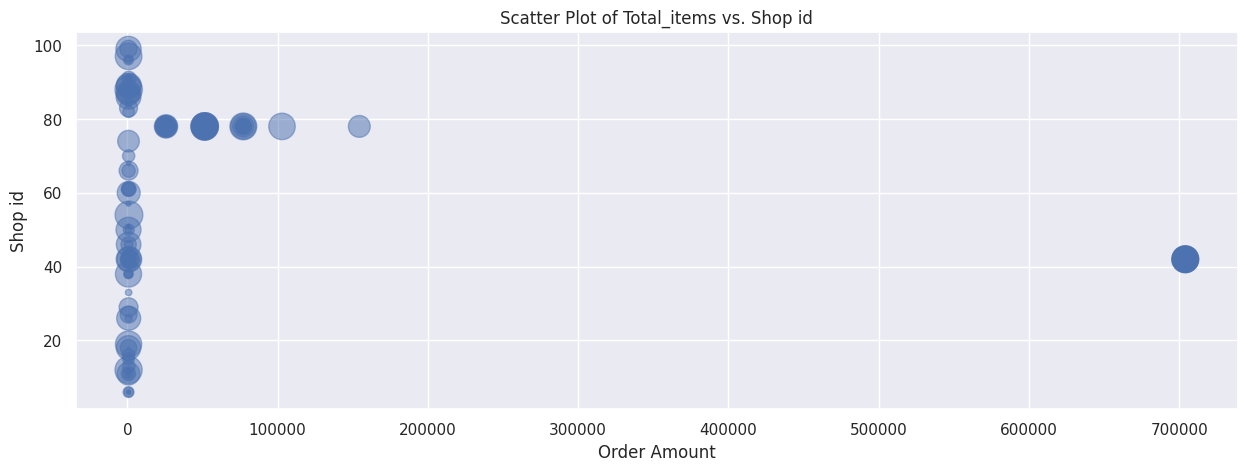

In [27]:
np.random.seed(200)
figure(figsize=(15, 5), dpi=100)
N = len(group2['order_amount'])
area = (20 * np.random.rand(N)) **2
plt.scatter(group2['order_amount'], group2['shop_id'], s=area, alpha=0.5)
plt.title('Scatter Plot of Total_items vs. Shop id')
plt.xlabel('Order Amount')
plt.ylabel('Shop id')

Text(0, 0.5, 'Count')

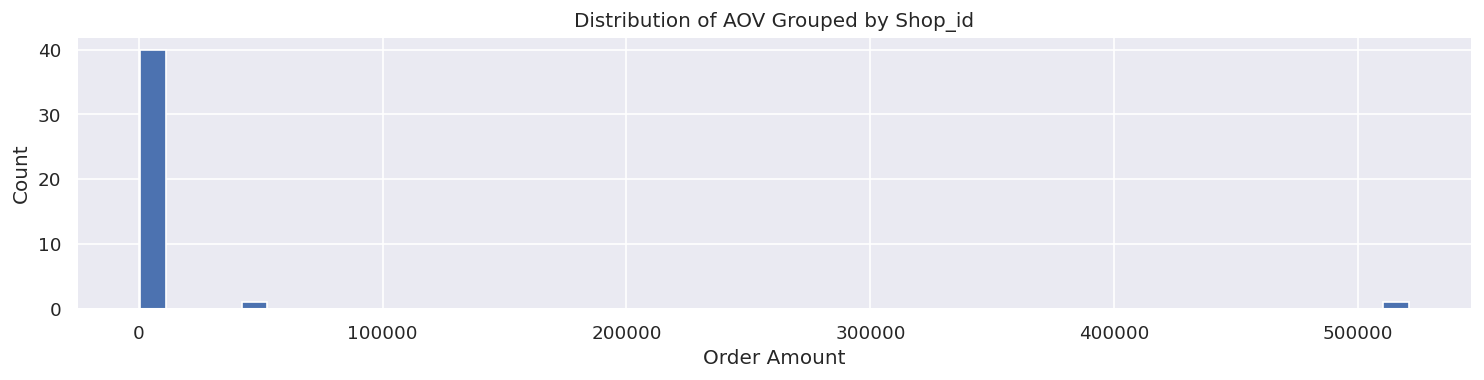

In [28]:
figure(figsize=(15, 3), dpi=120)
AOV_gb_order=group2.groupby('shop_id')['order_amount'].mean()
plt.hist(AOV_gb_order,bins=50)
plt.title('Distribution of AOV Grouped by Shop_id')
plt.xlabel('Order Amount')
plt.ylabel('Count')

In [29]:
group2.groupby('shop_id')['order_amount'].mean().sort_values(ascending=False).head()

shop_id
42    520684.521739
78     49213.043478
43      1086.000000
54      1064.000000
13       960.000000
Name: order_amount, dtype: float64

By observing how AOV grouped by shop distributed in group2 data set, we can find that shop NO.42 and NO.78 have extremely large volumns of order_amount. Let's have a look at all the orders of the two shops.


As for the orders of shop NO.42, we can see that the orders associated with the largest order_amount of 704,000 are all made by the user NO.607. The price per pair of sneakers is 352, which is not so expensive. However, the NO.607 user purchased a large quantity, 2000, every time. And the NO.607 user made 17 the same purchases in the 30 days window. Apart from the purchase of user NO.607, other users' purchase behavior in NO.42 shop is normal.

In [30]:
#All orders of shop NO.42
data_shop_42 = data[(data['shop_id']==42)].sort_values(ascending=False, by = 'order_amount')
data_shop_42

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at,price_per_item
15,16,42,607,704000,2000,credit_card,2017-03-07 04:00:00,352.0
1436,1437,42,607,704000,2000,credit_card,2017-03-11 04:00:00,352.0
4868,4869,42,607,704000,2000,credit_card,2017-03-22 04:00:00,352.0
4646,4647,42,607,704000,2000,credit_card,2017-03-02 04:00:00,352.0
4056,4057,42,607,704000,2000,credit_card,2017-03-28 04:00:00,352.0
3332,3333,42,607,704000,2000,credit_card,2017-03-24 04:00:00,352.0
2969,2970,42,607,704000,2000,credit_card,2017-03-28 04:00:00,352.0
2835,2836,42,607,704000,2000,credit_card,2017-03-28 04:00:00,352.0
2297,2298,42,607,704000,2000,credit_card,2017-03-07 04:00:00,352.0
1602,1603,42,607,704000,2000,credit_card,2017-03-17 04:00:00,352.0


The orders in shop NO.78 looks different from the ones in shop NO.42. It's apparent that the price of the sneakers that NO.78 shop sells is much higher than NO.42. Therefore, even buying one pair of sneaker from shop NO.42, the order_amount will exceed 25,000, which is far more than the upper bound of order_amount in the boxplot. 

In [31]:
#all order records of shop 78
data_shop_78 = data[(data['shop_id']==78)].sort_values(ascending=False, by = 'order_amount')
data_shop_78

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at,price_per_item
691,692,78,878,154350,6,debit,2017-03-27 22:51:43,25725.0
2492,2493,78,834,102900,4,debit,2017-03-04 04:37:34,25725.0
1259,1260,78,775,77175,3,credit_card,2017-03-27 09:27:20,25725.0
3724,3725,78,766,77175,3,credit_card,2017-03-16 14:13:26,25725.0
2906,2907,78,817,77175,3,debit,2017-03-16 03:45:46,25725.0
2690,2691,78,962,77175,3,debit,2017-03-22 07:33:25,25725.0
2564,2565,78,915,77175,3,debit,2017-03-25 01:19:35,25725.0
4192,4193,78,787,77175,3,credit_card,2017-03-18 09:25:32,25725.0
4420,4421,78,969,77175,3,debit,2017-03-09 15:21:35,25725.0
3403,3404,78,928,77175,3,debit,2017-03-16 09:45:05,25725.0


Although the sneakers sell at shop NO.78 is very expensive, they are very popular among the customers. In total, 46 different customers purchased from NO.78 shop.

In [32]:
#number of users purchased at NO.78 shop
num_user_78_shop =data[(data['shop_id']==78)]['user_id'].shape[0]
num_user_78_shop 

46

### (2) AOV group by user_id

Text(0, 0.5, 'User id')

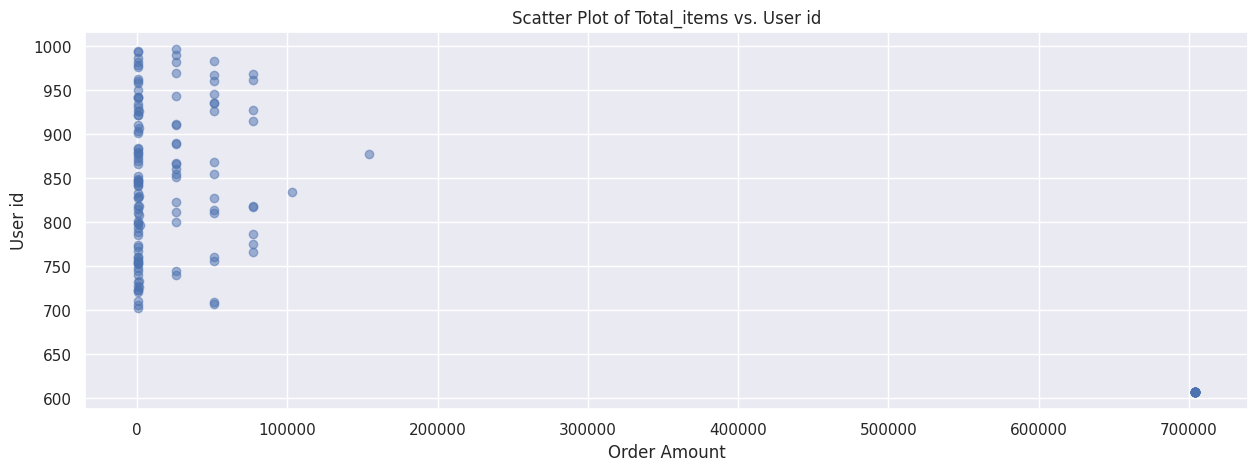

In [33]:
np.random.seed(200)
figure(figsize=(15, 5), dpi=100)
N = len(group2['order_amount'])
area = (20 * np.random.rand(N)) **2
plt.scatter(group2['order_amount'], group2['user_id'],alpha=0.5)
plt.title('Scatter Plot of Total_items vs. User id')
plt.xlabel('Order Amount')
plt.ylabel('User id')

Text(0, 0.5, 'Count')

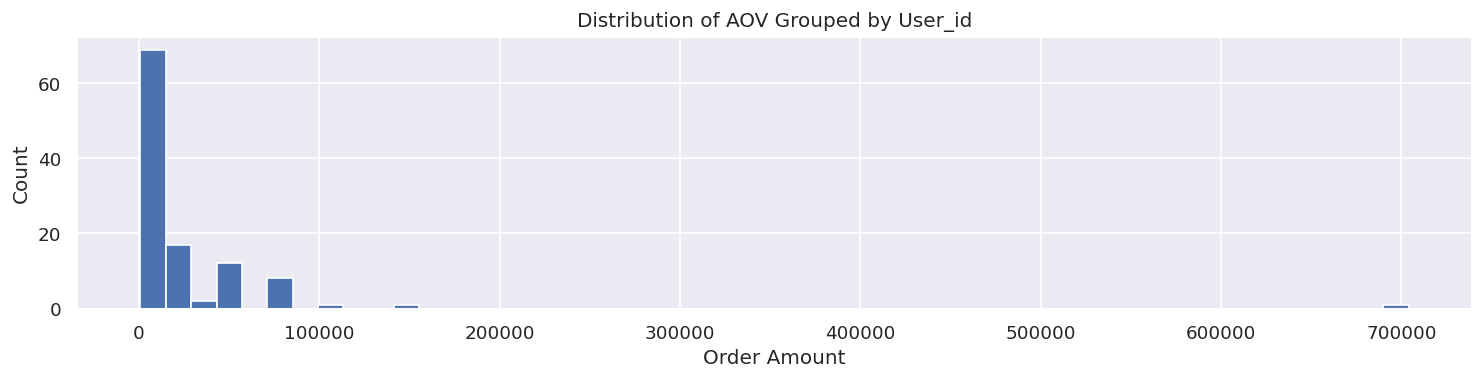

In [34]:
figure(figsize=(15, 3), dpi=120)
AOV_gb_order=group2.groupby('user_id')['order_amount'].mean()
plt.hist(AOV_gb_order,bins=50)
plt.title('Distribution of AOV Grouped by User_id')
plt.xlabel('Order Amount')
plt.ylabel('Count')

Similar to the purchase pattern of users shopped at NO.78 shop and the purchase pattern of NO.607 user at NO.42 shop, there are 46 customers are associated with AOV larger than 10,000 and 111  customers are associated with AOV larger than the upper bound. Customers are associated with AOV larger than 10,000 are those who purchased sneakers from NO.42 and NO.78 shop.

In [35]:
#customers with high value in AOV
user_with_high_AOV = group2.groupby('user_id')['order_amount'].mean().sort_values(ascending=False)
user_with_high_AOV.head(5)

user_id
607    704000.0
878    154350.0
834    102900.0
915     77175.0
928     77175.0
Name: order_amount, dtype: float64

In [36]:
user_with_high_AOV[user_with_high_AOV> 10000].shape[0]

46

In [37]:
user_with_high_AOV[user_with_high_AOV> upper_bound].shape[0]

111

### (3) AOV group by payment_method

There seems no evident differences among three different payment methods. To get more confident answer, we can use hypothesis testing and I am not going to cover it here.

Text(0, 0.5, 'Payment_method')

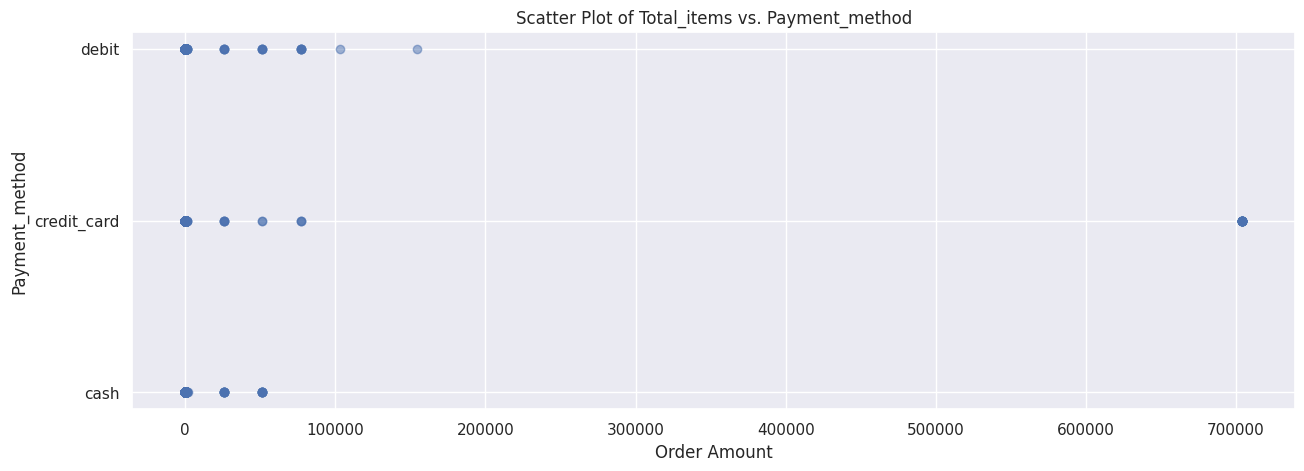

In [38]:
np.random.seed(200)
figure(figsize=(15, 5), dpi=100)
N = len(group2['order_amount'])
area = (20 * np.random.rand(N)) **2
plt.scatter(data['order_amount'], data['payment_method'],alpha=0.5)
plt.title('Scatter Plot of Total_items vs. Payment_method')
plt.xlabel('Order Amount')
plt.ylabel('Payment_method')

In [39]:
AOV_gb_pay=group2.groupby('payment_method')['payment_method'].count()
AOV_gb_pay

payment_method
cash           39
credit_card    55
debit          47
Name: payment_method, dtype: int64

### 3.4 Temporal analysis

Let's see how AOV distributed acorss time. Whether there exists a sudden change or a progressively change. From the below graph, it seems that the purchase records of NO.607 user at NO.42 shop is remarkable.

Text(0, 0.5, 'Order_amount')

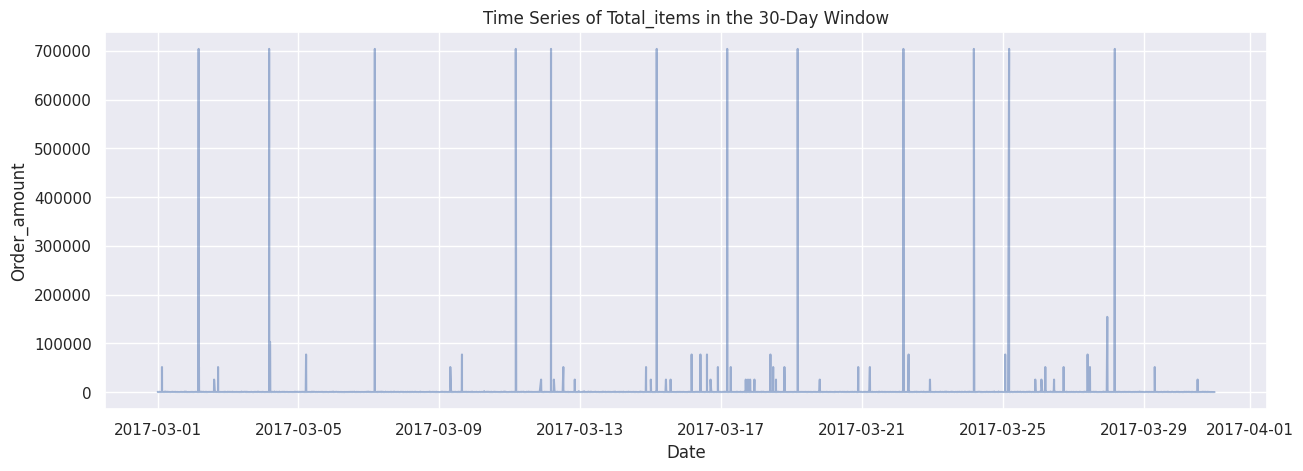

In [40]:
figure(figsize=(15, 5), dpi=100)
data_time = data.sort_values(by='created_at', ascending=True)['created_at']
data_order_amount= data.sort_values(by='created_at', ascending=True)['order_amount']
plt.plot(data_time, data_order_amount, alpha=0.5) 
plt.title('Time Series of Total_items in the 30-Day Window')
plt.xlabel('Date')
plt.ylabel('Order_amount')

After removing the purchase records of NO.607 user at NO.42 shop, we can see there is no apparent evidence that the AOV is increasing progressively. However, the extremely high value of order_amount made by NO.607 user at NO.42 shop as well as the order_amount at NO.78 shop can cause sudden surge in AOV on some day.

Text(0, 0.5, 'Order_amount')

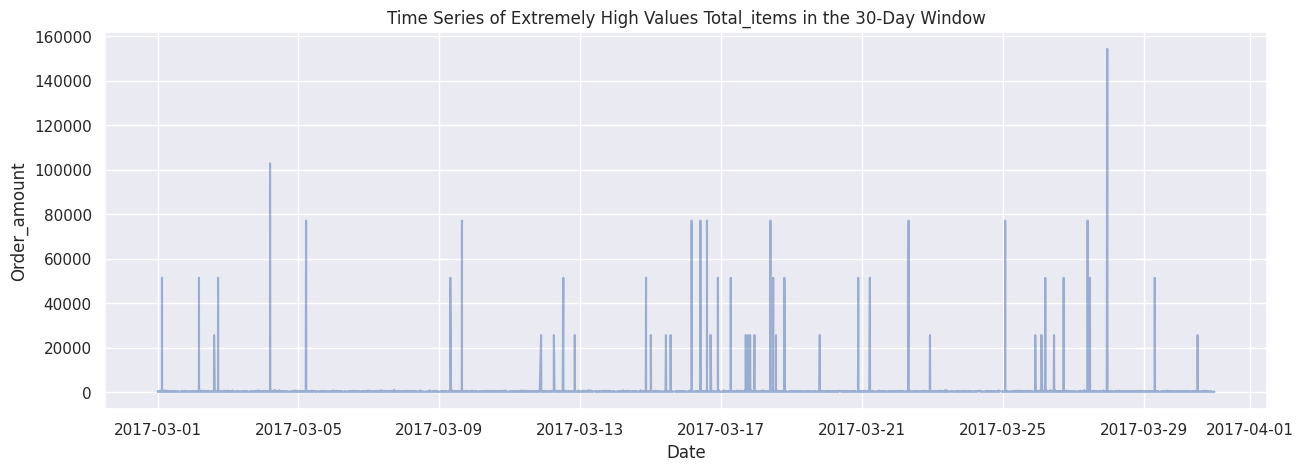

In [41]:
# removing purchase records of NO.607 user at NO.42 shop
figure(figsize=(15, 5), dpi=100)
data2=data[(data['user_id']!=607)&(data['shop_id']!=42)]
data2_time = data2.sort_values(by='created_at', ascending=True)['created_at']
data2_order_amount= data2.sort_values(by='created_at', ascending=True)['order_amount']
plt.plot(data2_time, data2_order_amount, alpha=0.5) 
plt.title('Time Series of Extremely High Values Total_items in the 30-Day Window')
plt.xlabel('Date')
plt.ylabel('Order_amount')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0, 0.5, 'Order_amount')

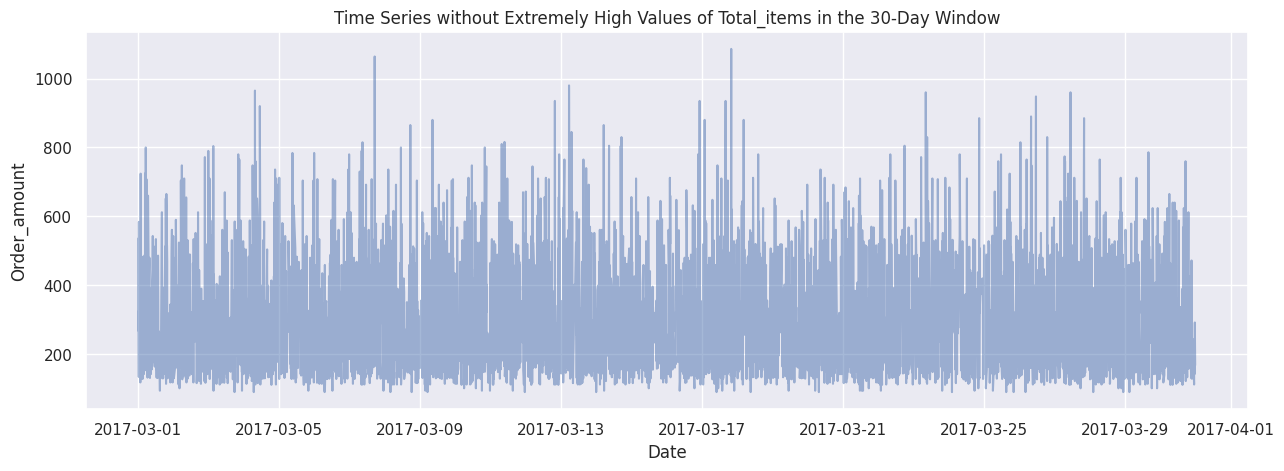

In [42]:
# removing sales records of NO.78 shop
figure(figsize=(15, 5), dpi=100)
data3=data2[data['shop_id']!=78]
data3_time = data3.sort_values(by='created_at', ascending=True)['created_at']
data3_order_amount= data3.sort_values(by='created_at', ascending=True)['order_amount']
plt.plot(data3_time, data3_order_amount, alpha=0.5) 
plt.title('Time Series without Extremely High Values of Total_items in the 30-Day Window')
plt.xlabel('Date')
plt.ylabel('Order_amount')

Let's see how extremely high value of order_amount of NO.607 user and NO.78 shops distributed across time.



It seems that NO.607 user purchased at NO.42 shop evenly during the 30 day's window.

Text(0, 0.5, 'Order_amount')

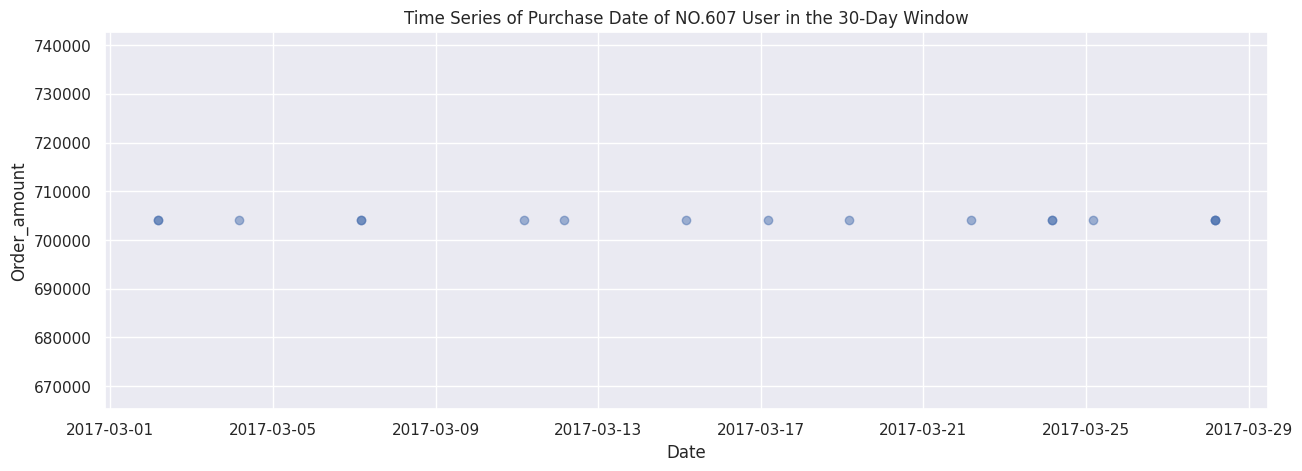

In [43]:
figure(figsize=(15, 5), dpi=100)
user_607_shop_42_time = group2[(group2['user_id']==607)&(group2['shop_id']==42)].sort_values(by='created_at', ascending=True)['created_at']
user_607_shop_42_order_amount= group2[(group2['user_id']==607)&(group2['shop_id']==42)].sort_values(by='created_at', ascending=True)['order_amount']
plt.scatter(user_607_shop_42_time, user_607_shop_42_order_amount, alpha=0.5) 
plt.title('Time Series of Purchase Date of NO.607 User in the 30-Day Window')
plt.xlabel('Date')
plt.ylabel('Order_amount')

Same order but with different order_id. May caused by manual mistake or technical issue.

In [51]:
data[(data['order_id']==2970)|(data['order_id']==2836)]

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at,price_per_item
2835,2836,42,607,704000,2000,credit_card,2017-03-28 04:00:00,352.0
2969,2970,42,607,704000,2000,credit_card,2017-03-28 04:00:00,352.0


The sales on NO.78 shop seems to have large value on 2017.03.05 and 2017.03.24, which can be considered as sudden change. There is little evidence of progressive increase in AOV at NO.78 shop.

Text(0, 0.5, 'Order_amount')

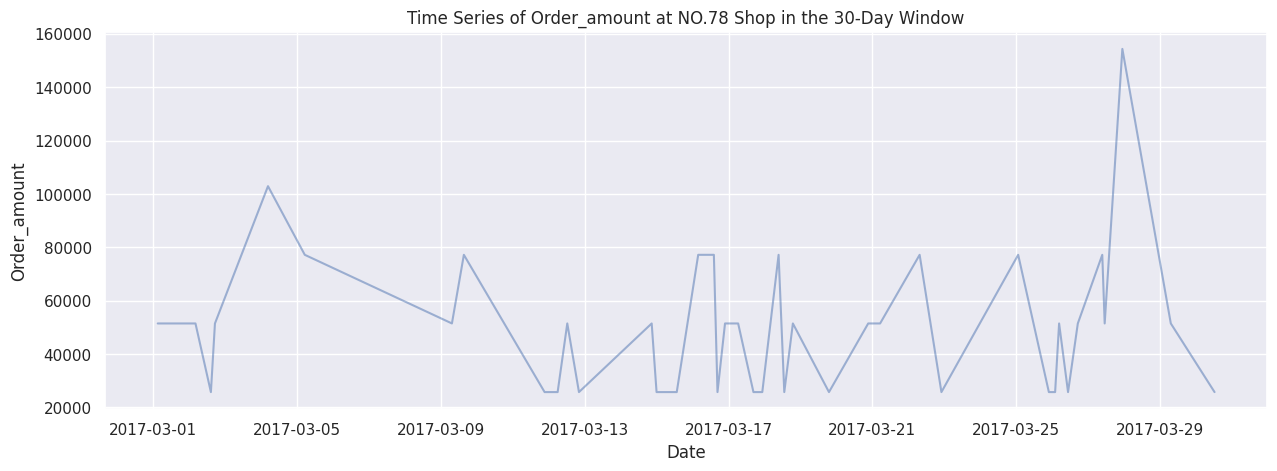

In [44]:
figure(figsize=(15, 5), dpi=100)
shop_78_time = group2[group2['shop_id']==78].sort_values(by='created_at', ascending=True)['created_at']
shop_78_order_amount= group2[group2['shop_id']==78].sort_values(by='created_at', ascending=True)['order_amount']
plt.plot(shop_78_time, shop_78_order_amount, alpha=0.5) 
plt.title('Time Series of Order_amount at NO.78 Shop in the 30-Day Window')
plt.xlabel('Date')
plt.ylabel('Order_amount')

## Section 4. Alternative Metric (Question 2&3)

### 4.1 Median Order Value

As shown before, the value of AOV will increase  If we remove the anomaly data of NO.607 User and NO.78 Shop, the value of AOV will decrease a lot (almost 1/10 of the original value of AOV).

In [45]:
print('AOV (all data):',data['order_amount'].mean())
print('AOV (after deleting data with price_per_items = 25725 and total_item=2000):',data[(data['price_per_item']!=25725)&(data['total_items']!=2000)]['order_amount'].mean())

AOV (all data): 3145.128
AOV (after deleting data with price_per_items = 25725 and total_item=2000): 302.58051448247926


In [46]:
data['order_amount'].mean()/data[(data['price_per_item']!=25725)&(data['total_items']!=2000)]['order_amount'].mean()

10.39435075777861

Therefore, as the averaged order value is too easy to be influced by extreme values, the median order value (**MOV**) can be a more rubost metric in comparison. 

In [47]:
MOV = data['order_amount'].median()
MOV

284.0

In [48]:
#MOV with and without anomaly data
print('MOV (all data):',data['order_amount'].median())
print('MOV (after deleting data with price_per_items = 25725 and total_item=2000):',data[(data['price_per_item']!=25725)&(data['total_items']!=2000)]['order_amount'].median())

MOV (all data): 284.0
MOV (after deleting data with price_per_items = 25725 and total_item=2000): 284.0


### 4.2 Revised AOV (after removing outliers)

We can also remove the extreme values to get a revised AOV.

In [49]:
data_extreme_value_removed = data[(data['price_per_item']!=25725)&(data['total_items']!=2000)]['order_amount']
print('AOV (after deleting data with price_per_items = 25725 and total_item=2000):', data_extreme_value_removed.mean())

AOV (after deleting data with price_per_items = 25725 and total_item=2000): 302.58051448247926
